### Object Detection with Caffe

At first stage, we will use Caffe Models for Object Detection

**Caffe**:  Caffe is a deep learning framework made with expression, speed, and modularity in mind. It is developed by Berkeley AI Research (BAIR) and by community contributors. Yangqing Jia created the project during his PhD at UC Berkeley. Caffe is released under the BSD 2-Clause license. 

http://caffe.berkeleyvision.org/

In this tutorial we will go through object detection using OpenCV and DNN features with Tensorflow and Caffe Framework

You can use following command to install missing packages

```python
!pip install opencv-python
```

In [1]:
# Lets import OpenCV library and Numpy
import cv2 as cv
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

OpenCV DNN Api needs Caffe's predefined neural network file and its weights representation as proto and model files. 

Caffe Model Zoo, has plenty of sample models in https://github.com/BVLC/caffe/wiki/Model-Zoo 

In this example, we will use MobileNetSSD model and proto files.

Model and Proto file can be accessed from: https://github.com/chuanqi305/MobileNet-SSD

#### Model File

Binary file generated by Caffe framework after traninig to reuse along with all different platforms. Underlying data is the neural net configurations and weights.

#### Proto

Human readable text file used for training of models and define the Convolutional Neural Networks parameters and configurations.

In this example, we will use MobileNetSSD models. 


In [2]:
# here is the models 
caffe_model = 'models/MobileNetSSD_deploy.caffemodel'
caffe_proto = 'models/MobileNetSSD_deploy.prototxt'

#if files are not loaded, download from:

import os.path
import urllib.request

if not os.path.isfile(caffe_model):
    print('File Not Found: ', caffe_model)
    caffe_model_path = 'https://github.com/chuanqi305/MobileNet-SSD/blob/master/MobileNetSSD_deploy.caffemodel?raw=true'
    print('Downloading .... : ', caffe_model_path)
    urllib.request.urlretrieve(caffe_model_path, caffe_model)
    print('Download Finished: ', caffe_model_path)
    
if not os.path.isfile(caffe_proto):
    print('File Not Found: ', caffe_proto)
    caffe_proto_path = 'https://raw.githubusercontent.com/chuanqi305/MobileNet-SSD/master/MobileNetSSD_deploy.prototxt'
    print('Downloading .... : ', caffe_proto_path)
    urllib.request.urlretrieve(caffe_proto_path, caffe_proto)
    print('Download Finished: ', caffe_proto_path)

In [3]:
#caffe model labels for objects are predefined for MobileNetSSD caffe model and protbuf
labels = ("background", "aeroplane", "bicycle", 
          "bird", "boat", "bottle", "bus", 
          "car", "cat", "chair", "cow", 
          "diningtable", "dog", "horse", 
          "motorbike", "person", "pottedplant", 
          "sheep", "sofa", "train", "tvmonitor")

#label_colors = np.random.uniform(0, 255, (len(labels),3))
# we generated random colors for each label to determine object on frame
label_colors = [[ 70.03036239,  53.39948712, 221.96066983],
                   [ 72.40459246,  81.85653543, 216.79091508],
                   [ 16.05095266, 156.74660586,  28.22137944],
                   [ 22.14580474, 245.30084464, 203.24240217],
                   [ 67.87645208,  61.44175277,  62.59789847],
                   [252.36723978,   5.40010433,  73.84552673],
                   [207.95470272,  96.58437259,  17.00872131],
                   [108.9367236 , 180.97081026,  78.16660705],
                   [237.0586842 , 160.01565458, 106.49361722],
                   [131.40428931,  43.9492775 , 222.22671871],
                   [109.40802485, 123.90466382, 208.49082336],
                   [241.25056538, 246.46355905, 215.40549655],
                   [ 50.53963961, 188.7669464 ,  14.91525421],
                   [104.91164983,  13.90156432,  80.97275078],
                   [ 65.87683959, 160.34697271, 199.46650188],
                   [ 16.08423214,  84.441482  , 163.3640731 ],
                   [ 68.50589207,  65.21968418, 229.81699866],
                   [151.91579089, 195.49198107,  94.49696933],
                   [132.74947445,  14.51457431, 163.51873436],
                   [ 83.84690577, 178.29185705, 128.78807612],
                   [195.2857407 , 247.73377045, 175.55730603]]

OpenCV has been enabled to work with Deep Neural Network frameworks including Caffe to load models and neural network instead of haar cascade files for object detection.

OpenCV dnn API provides readNetFromCaffe method to load pre-trained Caffe models.

In [4]:
net = cv.dnn.readNetFromCaffe(caffe_proto, caffe_model)

Now, we will make OpenCV DNN to get image to generate a blob after mean subtraction, normalizing, and channel swapping.

**blob**: (A Binary Large OBject) 4-dimensional blob from series of images.

Which is eventually required input for neural network for detecting objects

In [5]:
# Let's define and open an existing image from our resources
source_image = '../images/street/YellowWhite.jpg'
img = cv.imread(source_image)

In [6]:
# Now, we open the image we want to run object detection of MobileNetSSD model.



#blobFromImage: 
# Creates 4-dimensional blob from series of images. Optionally resizes and crops images from center, 
# subtract mean values, scales values by scalefactor, swap Blue and Red channels.

# Neural net uses image to generate detected object list with given parameters, these parameters can be found from:
#  https://github.com/opencv/opencv/tree/master/samples/dnn 

# First we get image size
orig_rows = img.shape[0]
orig_cols = img.shape[1]

rows = 300
cols = 300

resized_img = cv.resize(img,(rows,cols))

blob = cv.dnn.blobFromImage(resized_img, 0.00784, (rows, cols), (127.5, 127.5, 127.5), swapRB=True, crop=False)

# send blob input to neural net 
net.setInput(blob)

Detected: 
car 0.3602
car 0.2893


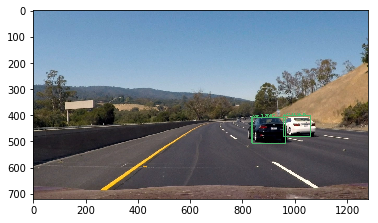

In [7]:
# forward method is asking all detected objects
out = net.forward()

# confidence is used as thresheold for confidence for the detected object.
# this means how the object fitted to detected object
confidence = 0.2

print('Detected: ')
## here we get the data for each detected object in the blob
for detection in out[0,0,:,:]:
    #confidence score
    score = float(detection[2])
    
    #label index
    label_index = int(detection[1])

    # draw rectangle and write the name of the object if above given confidence
    if score > confidence:
        left = detection[3] * cols
        top = detection[4] * rows
        right = detection[5] * cols
        bottom = detection[6] * rows
        
        label_text = labels[label_index] +  " " + str(round(score, 4))
        print(label_text)
        cv.putText(resized_img, label_text, (int(left), int(top)), cv.FONT_HERSHEY_SIMPLEX, 0.5, label_colors[label_index], 2)       
        cv.rectangle(resized_img, (int(left), int(top)), (int(right), int(bottom)), label_colors[label_index], thickness=3)
        

        #original image
        row_factor = orig_rows/300.0  
        col_factor = orig_cols/300.0
        
        # Scale object detection to original image
        left = int(col_factor * left) 
        top = int(row_factor * top)
        right   = int(col_factor * right)
        bottom   = int(row_factor * bottom)
        
        cv.putText(img, label_text, (int(left), int(top)), cv.FONT_HERSHEY_SIMPLEX, 0.5, label_colors[label_index], 2)       
        cv.rectangle(img, (int(left), int(top)), (int(right), int(bottom)), label_colors[label_index], thickness=3)
        
# show image on a window
#cv.imshow('img', img)
#print image on notebook, Cars has been detected
#plt.imshow(cv.cvtColor(resized_img, cv.COLOR_BGR2RGB))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
#cv.waitKey()

## Resources

- https://github.com/opencv/opencv/tree/master/samples/dnn
- https://github.com/opencv/opencv/blob/master/samples/dnn/object_detection.py
